Bayesian Optimizing QAOA Circuit Energy
=======================================

In this quantum circuit example, we'll optimize a 54-qubit, $p=4$ (depth 12), QAOA 
circuit on a random 3-regular graph, with respect to its energy - a sum of local 
expectations.

In [1]:
%config InlineBackend.figure_formats = ['svg']

import quimb as qu
import quimb.tensor as qtn

First we instantiate a high quality contraction path finder from ``cotengra``,
because each energy term will be a unique contraction, we'll make a 
'reusable' optimizer that can be used on multiple different contractions.

In [2]:
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={}, 
    max_repeats=16,
    parallel=True,
    # use the following for persistently cached paths
    # directory='ctg_path_cache',
)

Setting Up the Circuit
----------------------

Then we generate a random regular graph of conditions to satisfy. Optimizing
the antiferromagnetic coupling on this graph is equivalent to trying to solve
the MAX-CUT problem.

In [3]:
import networkx as nx

reg = 3
n = 54
seed = 666
G = nx.random_regular_graph(reg, n, seed=seed)

terms = {(i, j): 1 for i, j in G.edges}

`quimb` has a built-in QAOA circuit ansatz, which takes the dict of couplings
to weights, as well as the $\beta$ and $\gamma$ parameters describing gate
rotations:

In [4]:
p = 4
gammas = qu.randn(p)
betas = qu.randn(p)
circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)

The overall circuit this generates is very complex:

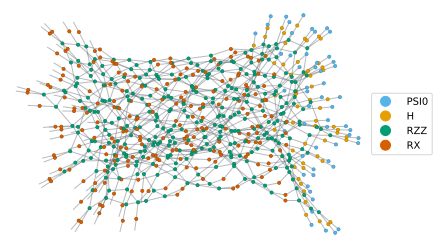

In [5]:
circ_ex.psi.draw(color=['PSI0', 'H', 'RZZ', 'RX'])

But because of the unitary structure of quantum circuits, local quantities can usually
be significantly simplified (automatically by ``quimb``). Here, e.g., is the simplfied
tensor network describing the reduced density matrix of qubit 0 only:

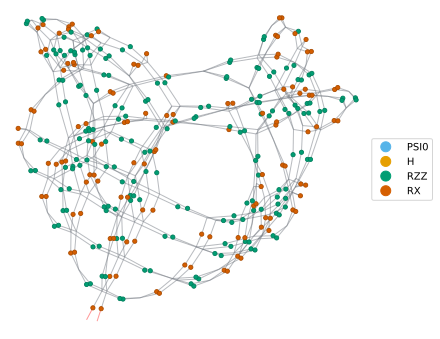

In [6]:
circ_ex.get_rdm_lightcone_simplified([0]).draw(color=['PSI0', 'H', 'RZZ', 'RX'], highlight_inds=['k0', 'b0'])

Rehearsing the Computation
--------------------------

Before we actually compute the QAOA energy, its usually worth 'rehearsing' it -
finding the contraction widths and costs of each energy term to check they are 
not too big. The contraction paths found (which can take some time), will be 
cached by the `ReusableHyperOptimizer` for the actual computation later.

In [7]:
import tqdm

ZZ = qu.pauli('Z') & qu.pauli('Z')

local_exp_rehs = [
    circ_ex.local_expectation_rehearse(weight * ZZ, edge, optimize=opt)
    for edge, weight in tqdm.tqdm(list(terms.items()))
]

100%|██████████| 81/81 [06:34<00:00,  4.87s/it]


If we plot these we can see that the size of each and the number of ops is
very moderate:

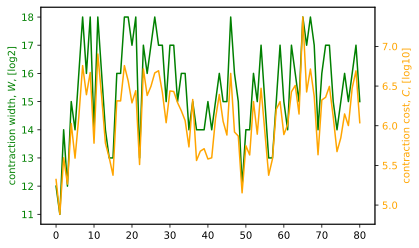

In [8]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot([rehs['W'] for rehs in local_exp_rehs], color='green')
ax1.set_ylabel('contraction width, $W$, [log2]', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot([rehs['C'] for rehs in local_exp_rehs], color='orange')
ax2.set_ylabel('contraction cost, $C$, [log10]', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

In fact, the actual contractions will probably not be the most time consuming
part of the computation.

Bayesian Optimizing the Energy
------------------------------

Since we only have $2 p=8$ variational parameters we can easily apply something
like Bayesian optimization to minimize the energy. 

We'll use ``scikit-optimize`` here, but many gradient free optimizers could be 
used instead. Most simply require casting the problem function as taking a 
single vector of parameters - ``x``:

In [9]:
def energy(x):
    p = len(x) // 2
    gammas = x[:p]
    betas = x[p:]
    circ = qtn.circ_qaoa(terms, p, gammas, betas)

    ZZ = qu.pauli('Z') & qu.pauli('Z')
    ens = [
        circ.local_expectation(weight * ZZ, edge, optimize=opt)
        for edge, weight in terms.items()
    ]
    
    return sum(ens).real

Now we can setup some bounds for our parameters and the optimizer object itself:

In [10]:
from skopt import Optimizer
from skopt.plots import plot_convergence, plot_objective

In [11]:
eps = 1e-6
bounds = (
    [(0.0        + eps, qu.pi / 2 - eps)] * p + 
    [(-qu.pi / 4 + eps, qu.pi / 4 - eps)] * p
)

bopt = Optimizer(bounds)

For the actual minimization, we ask the optimizer to suggest a vector of
parameters to sample, then simply report the corresponding energy:

In [12]:
for i in tqdm.trange(100):
    x = bopt.ask()
    res = bopt.tell(x, energy(x))

100%|██████████| 100/100 [1:05:33<00:00, 39.33s/it]


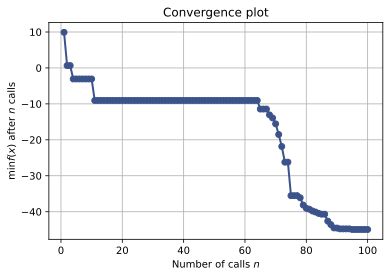

In [13]:
plot_convergence(res);

One of the advantages of using Bayesian optimization and ``scikit-optimize`` is
that we get an estimate of the actual energy landscape we can visualize:

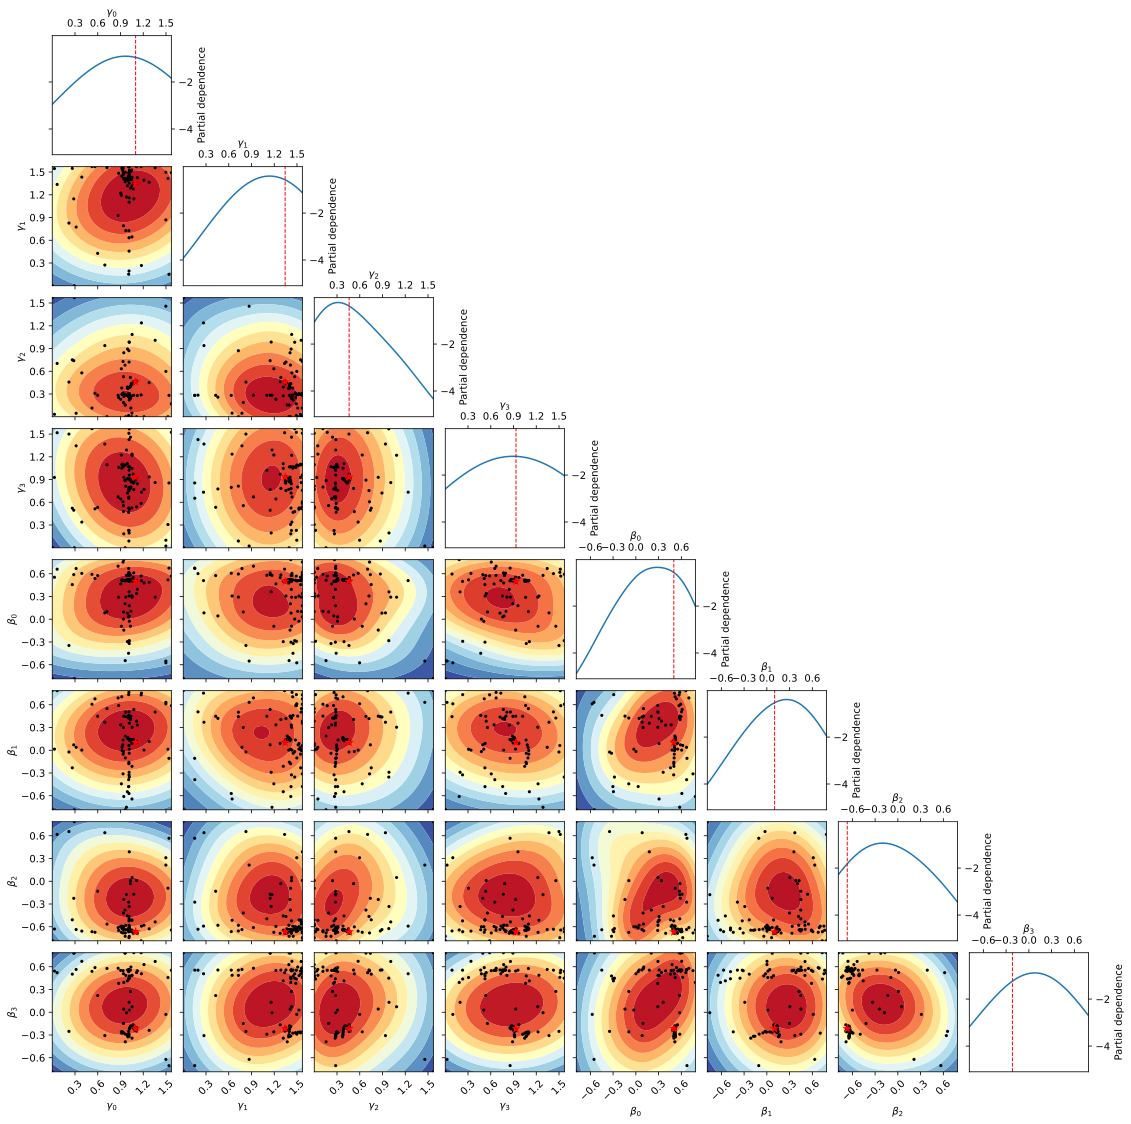

In [14]:
plot_objective(
    res, 
    cmap='RdYlBu_r',
    dimensions=[f'$\\gamma_{i}$' for i in range(p)] + [f'$\\beta_{i}$' for i in range(p)],
);